# Example for post-processing output data
This notebook servers as a usage example for data post-processing of the freva plugin climpact. In a first processing step the data has been processed and stored in the cloud by the freva plugin. It is very likely that this data hasn't been processed sufficiently, e.g unit conversion of the variables is necessary, calculating new variables are. This step, which is highly individual, can be done in this notebook with just a few commands.

Here we assume that the the data has already been produced by the freva plugin and was successfully stored in the cloud. 

For working with this data the plugin also comes with a library which creates so called data-containers allowing for easy access of the data in the cloud. 


Hence before we start working, we import all necessary libraries.

In [1]:
%matplotlib inline
import xarray as xr
from climpact import DataContainer
import metpy.calc

## Calculating the LCL
In this example we are going to calculate the lifted condensation level (LCL) from temperature, pressure and relative humidity. To calculate the LCL we are using the `metpy` library. First we open the data that has been processed by the plugin and was saved into the cloud. This can be done by the `from_zipfile`. This method will open the dataset in the cloud, read its content and create a so called data container

In [2]:
data_container = DataContainer.from_zipfile(
    "https://swift.dkrz.de/v1/dkrz_3d3c7abc-1681-4012-b656-3cc1058c52a9/climpact/k204230/ProcessedModelData-nukleus-ger-3km-tdps_ts_ps_pr-20220131_111203T.zip"
)
data_container

Downloading: 100%|██████████████████████████████████████████████████| 72.2k/72.2k [00:00<00:00, 1.66MB/s]


model name
index                                     
0      ecmwf-eraint-gerics-remo2015_r1i1p1

This convenient html representation of the data-containers content shows the model member(s) belonging to this data container. We can also inspect the variables that are stored within the data container:

In [3]:
data_container.variables

['tdps', 'ts', 'ps', 'pr']

The individual model datasets can be accessed by index or model names according to table above, using the select method. For example:

In [4]:
dset = data_container.select(by_name="ecmwf-eraint-gerics-remo2015_r1i1p1") # or 
dset = data_container.select(by_index=0)
dset

<xarray.Dataset>
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 2009-06-01T00:30:00 ... 2009-06-29T23:30:00
Data variables:
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    tdps     (time) float64 284.4 284.3 284.2 284.1 ... 284.3 283.9 283.8 283.7
    ts       (time) float64 285.9 285.6 285.3 285.1 ... 291.2 290.3 289.6 289.1
    ps       (time) float64 9.87e+04 9.871e+04 9.872e+04 ... 9.861e+04 9.863e+04
    pr       (time) float64 9.504e-05 5.129e-05 2.84e-05 ... 1.101e-11 2.56e-09
Attributes: (12/41)
    CDI:                            Climate Data Interface version 1.9.8 (htt...
    history:                        Mon Mar 29 17:28:32 2021: cdo -O -s -f nc...
    Conventions:                    CF-1.6
    tracking_id:                    ed6f10e1-3780-4fba-a454-110790c8bbc3
    creation_date:                  2021-03-29T17:28:32Z
    CDO:                            Climate Data Operators version 1.9.8 (htt...
    ...                             ...
    ensemble_member:                ecmwf-eraint-gerics-remo2015_r1i1p1
    experiment:                     evaluation
    output_freqeuncy:               1hr
    shape_file:                     /work/ch1187/regiklim-work/k204230/German...
    swift_group:                    ch1187
    path_prefix:                    ProcessedModelData-nukleus-ger-3km-tdps_t...

This dataset is a so called [xarray dataset](https://xarray.pydata.org/en/stable/index.html).  Xarray is a very powerful library that lets you handle multi-dimensional labeled data arrays. It allows for easy manipulation, visualisation of the underlying data. For example, we can conveniently plot precipitation time-series:

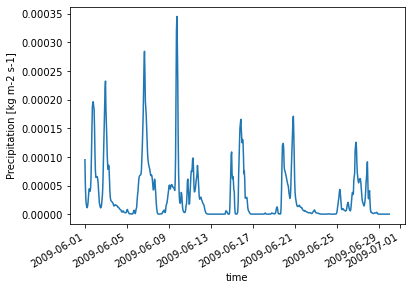

In [5]:
%matplotlib inline
dset['pr'].plot()

We see the precipitation is given in `kg/m^2/s` which is according to cf-convention but not very convenient. The data-container offers a method to convert variables units. For example can we convert all units of a given variable to a given target variable, say `mm/hour`:

In [6]:
data_container.convert("pr", "mm/hour")

This converts all precipitation data arrays to `mm/hour`. By default the dataset that has been selected by the `select` method is a so called reference to the data in the data container. Hance changes to either the data-container or the selected dataset will be reflected in both, data-container and selected dataset:

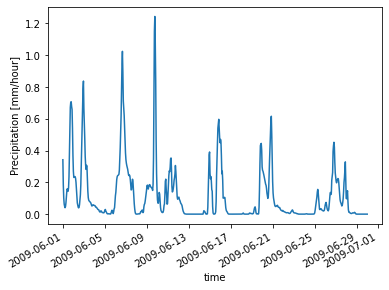

In [7]:
%matplotlib inline
dset['pr'].plot()

With help of the xarray plotting libary we can inspect the data a little further. For instance comparing the relationship of surface pressure and precipitation:

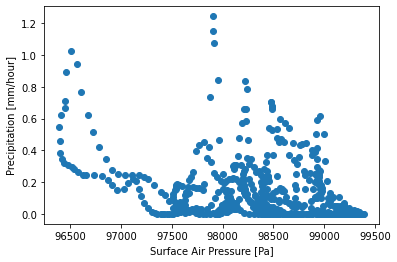

In [8]:
%matplotlib inline
xr.plot.scatter(dset, 'ps', 'pr')

Now let's define a function that calculates the lifted condensation level (lcl):

In [9]:
def lcl(input_data: xr.Dataset) -> xr.Dataset:
    """Calculate the lifted condenstation level with help of metpy.
    
    Parameters:
    -----------
    input_data:
        Dataset holding data arrays for surface temperature, surface dewpoint and surface pressure
        
    Returns:
    --------
    Lcl added dataset
    """
    lcl_pres, lcl_temp = metpy.calc.lcl(dset.ps, dset.ts, dset.tdps)
    # Calculate the hight of the LCL in km
    lcl_in_km = metpy.calc.pressure_to_height_std(lcl_pres)
    # Create an xarray DataArray from the lcl height
    lcl_data = xr.DataArray(
        lcl_in_km.magnitude,
        coords=dset.ts.coords,
        dims=dset.ts.dims,
        name="lcl",
        attrs=dset.ts.attrs
    )
    # Attributes from the surface temperature have been added, adjust them to lcl specific ones
    lcl_data.attrs["units"] = "km"
    lcl_data.attrs["standard_name"] = "lcl"
    lcl_data.attrs["long_name"] = "Lifted condensation level"
    lcl_data.attrs.pop("code", "")
    # Add the lcl data to the input dataset
    dset["lcl"] = lcl_data

Now calculate the lcl for all datasets in the data container. We could use the select method or simply loop over the container:

In [10]:
for data in data_container:
    lcl(data)
# Check the variables that are in the data_container
print(data_container.variables)

['tdps', 'ts', 'ps', 'pr', 'lcl']


In [11]:
# Inspect the data set for lcl
data_container.select(by_index=0).lcl

<xarray.DataArray 'lcl' (time: 696)>
array([0.41456444, 0.38369606, 0.355973  , 0.34096036, 0.38573349,
       0.48194181, 0.60859884, 0.75559301, 0.88659971, 0.99915582,
       1.08952576, 1.13127652, 1.13173516, 1.0924129 , 1.03527414,
       0.95968042, 0.87677191, 0.78879979, 0.69924412, 0.6265866 ,
       0.57301881, 0.538067  , 0.51036379, 0.48029791, 0.44640516,
       0.41637347, 0.39702045, 0.3861391 , 0.39138702, 0.41059171,
       0.44804307, 0.50093626, 0.56573122, 0.63705818, 0.69233004,
       0.73383446, 0.75670915, 0.75382099, 0.72976079, 0.689635  ,
       0.63998925, 0.57509006, 0.51027125, 0.47291393, 0.44918392,
       0.43141892, 0.42290889, 0.42053975, 0.42232433, 0.43172892,
       0.44603137, 0.45513331, 0.46913105, 0.5125712 , 0.58794883,
       0.67955442, 0.77308422, 0.84896457, 0.9128196 , 0.9654411 ,
       0.99852701, 1.00744187, 0.99205492, 0.95808374, 0.9063193 ,
       0.8339873 , 0.74800021, 0.68213717, 0.63009184, 0.58461539,
       0.54196965, 0.50393472, 0.47118584, 0.44499188, 0.42515909,
       0.41433054, 0.45054905, 0.54562726, 0.70021679, 0.88734801,
       1.08757643, 1.27669202, 1.44978291, 1.5341508 , 1.56589514,
       1.56285456, 1.52191435, 1.45120444, 1.35485245, 1.23400826,
       1.09329362, 0.98499826, 0.90396661, 0.83911082, 0.78692378,
       0.74712609, 0.71848973, 0.69195525, 0.66645964, 0.64339156,
...
       0.65538609, 0.64113295, 0.63481578, 0.63525513, 0.67630819,
       0.74630743, 0.84794017, 0.9885651 , 1.12710127, 1.23873637,
       1.31604845, 1.36330918, 1.3647003 , 1.32375084, 1.28670149,
       1.23060523, 1.14479746, 1.04018063, 0.92592406, 0.83216509,
       0.77210266, 0.72258264, 0.68019768, 0.64522123, 0.61988448,
       0.60444304, 0.59576371, 0.59215917, 0.60221133, 0.61956134,
       0.64659544, 0.69911054, 0.77411926, 0.84812679, 0.92056375,
       0.98297265, 1.02543236, 1.04405836, 1.04715214, 1.02562276,
       0.97640154, 0.8953255 , 0.8024732 , 0.72806643, 0.67882643,
       0.6447539 , 0.61468327, 0.58728271, 0.55675154, 0.53322448,
       0.51414786, 0.50332888, 0.52412028, 0.58223875, 0.66489977,
       0.81063743, 0.97349592, 1.12970717, 1.26703043, 1.35844563,
       1.41154176, 1.43238367, 1.4181825 , 1.37421005, 1.29709732,
       1.17473155, 1.01938131, 0.90035012, 0.81550632, 0.74073127,
       0.68099528, 0.63726098, 0.60419687, 0.58104336, 0.56347001,
       0.5568276 , 0.62775997, 0.75258238, 0.88919377, 1.12277409,
       1.3494008 , 1.50700854, 1.61980845, 1.6905923 , 1.72002803,
       1.72028893, 1.69239446, 1.63927243, 1.55544829, 1.41552857,
       1.25865598, 1.1577942 , 1.08911537, 1.02139888, 0.95856849,
       0.90222675])
Coordinates:
  * time     (time) datetime64[ns] 2009-06-01T00:30:00 ... 2009-06-29T23:30:00
Attributes:
    standard_name:  lcl
    long_name:      Lifted condensation level
    units:          km
    grid_mapping:   rotated_pole

In [12]:
# Convert the lcl's in the data container from km to m
data_container.convert("lcl", "m")
dset = data_container.select(by_name="ecmwf-eraint-gerics-remo2015_r1i1p1")
dset.lcl

<xarray.DataArray 'lcl' (time: 696)>
array([ 414.5644378 ,  383.69605915,  355.97299583,  340.96036309,
        385.73348664,  481.94181487,  608.59884232,  755.5930091 ,
        886.59971001,  999.1558183 , 1089.52576375, 1131.27651758,
       1131.73515841, 1092.41290095, 1035.27413796,  959.6804189 ,
        876.77190869,  788.79979298,  699.24412234,  626.58659954,
        573.01880798,  538.0669983 ,  510.36379247,  480.29791191,
        446.40515614,  416.37347408,  397.02045094,  386.13909966,
        391.38701594,  410.59171114,  448.04307461,  500.93625945,
        565.73122045,  637.05817754,  692.3300373 ,  733.83445809,
        756.70914823,  753.82098729,  729.76079456,  689.63499863,
        639.98924572,  575.09006003,  510.27125066,  472.91392586,
        449.1839199 ,  431.41891788,  422.90888543,  420.53975406,
        422.32433343,  431.72892105,  446.03136641,  455.13330995,
        469.1310462 ,  512.57120465,  587.9488322 ,  679.55441899,
        773.08422263,  848.96456948,  912.81960373,  965.44110408,
        998.52700889, 1007.44187022,  992.05492358,  958.0837391 ,
        906.31929781,  833.98729592,  748.00020826,  682.13717132,
        630.09183837,  584.61538785,  541.96964883,  503.9347241 ,
        471.18583847,  444.99187626,  425.15908537,  414.33053831,
        450.54905204,  545.62725737,  700.21678691,  887.34801284,
...
       1144.79746375, 1040.18062626,  925.9240616 ,  832.16508543,
        772.10265583,  722.58263823,  680.19767623,  645.22122723,
        619.88447604,  604.4430426 ,  595.76370818,  592.1591668 ,
        602.21133413,  619.56133992,  646.5954379 ,  699.11054352,
        774.1192632 ,  848.12679433,  920.56374811,  982.97264855,
       1025.43236038, 1044.05836362, 1047.15214328, 1025.62275534,
        976.40154228,  895.325497  ,  802.47319732,  728.06642892,
        678.82642769,  644.75390177,  614.68326779,  587.28271063,
        556.75154153,  533.22448309,  514.14786255,  503.3288788 ,
        524.12027762,  582.23875364,  664.89977375,  810.6374289 ,
        973.49591538, 1129.70717   , 1267.0304347 , 1358.44563439,
       1411.54176014, 1432.38367427, 1418.18249975, 1374.21005009,
       1297.09732461, 1174.73154963, 1019.38131209,  900.35011577,
        815.50632413,  740.73127188,  680.99527516,  637.26098311,
        604.19687303,  581.04335869,  563.47001387,  556.82760316,
        627.75997263,  752.5823834 ,  889.19376885, 1122.77409186,
       1349.40080369, 1507.00854062, 1619.80845054, 1690.59229688,
       1720.02803088, 1720.28893154, 1692.39446305, 1639.27242536,
       1555.44829345, 1415.52856507, 1258.65597877, 1157.79420204,
       1089.11536672, 1021.39888425,  958.56848661,  902.22674736])
Coordinates:
  * time     (time) datetime64[ns] 2009-06-01T00:30:00 ... 2009-06-29T23:30:00
Attributes:
    standard_name:  lcl
    long_name:      Lifted condensation level
    units:          m
    grid_mapping:   rotated_pole

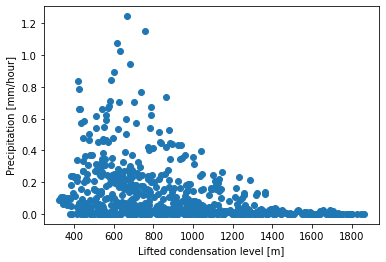

In [13]:
%matplotlib inline
xr.plot.scatter(dset, "lcl", "pr")

We have calculated the lifted condensation level. Now it is time time to save the processed data for future usage. This is done by applying the `save` method. This method pushes the new dataset into cloud where it is ready for download. The data will be save into zip files. For data files themselves you can choose between the following extensions:

-  `nc` for netcdf4 files, 
- `h5` for hdf5 files,
- `csv` for text based csv files.

In [14]:
data_container.save(filetype='csv')